In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import cv2
from imutils import face_utils
import dlib 
import imutils
import os
from sklearn.preprocessing import MinMaxScaler
from google.colab.patches import cv2_imshow
from skimage.transform import resize
import imageio

In [ ]:
speakers = ['F01','F02','F04','F05','F06','M01','M02','M04','M07','M08'] 
word_folder = ['01','02','03']
varieties = ['01','02','03','04','05','06','07','08', '09', '10']
words = ['Begin', 'Choose', 'Connection']

Save lip images from data

In [ ]:
# os.mkdir('/content/gdrive/My Drive/lip_reading/mouth')
# for speaker in speakers:
#   os.mkdir('/content/gdrive/My Drive/lip_reading/mouth/'+speaker)
#   for ind, folder in enumerate(word_folder):
#     os.mkdir('/content/gdrive/My Drive/lip_reading/mouth/'+speaker+'/' +folder)
#     for vari in varieties:
#       os.mkdir('/content/gdrive/My Drive/lip_reading/mouth/'+speaker+'/' +folder+'/' +vari)
#       image_list=os.listdir('/content/gdrive/My Drive/lip_reading/dataset/dataset/'+speaker+'/'+'words/'+folder+'/'+vari)
#       sequence = []
#       for im in image_list:
#         image = cv2.imread('/content/gdrive/My Drive/lip_reading/dataset/dataset/'+speaker+'/'+'words/'+folder+'/'+vari+'/'+im,0)
#         face=dlib.get_frontal_face_detector()(image,1)
#         for each in face:
#           face_points=dlib.shape_predictor('/content/gdrive/My Drive/lip_reading/shape_predictor_68_face_landmarks.dat')(image,each)
#           face_points = face_utils.shape_to_np(face_points)
#           (x, y, w, h) = cv2.boundingRect(np.array([face_points[49:68]]))     # 48-68 mouth points
#           mouth = image[y:y+h, x:x+w]
#           # mouth = imutils.resize(mouth, height=150 ,width = 250, inter=cv2.INTER_CUBIC)
#           mouth = cv2.resize(mouth, (200, 100))
#           print(speaker)
#           print(folder)
#           cv2_imshow(mouth)
#           cv2.imwrite('/content/gdrive/My Drive/lip_reading/mouth/'+speaker+'/' +folder+'/' +vari +'/' + im, mouth)

Read lip image and preprocessing step

In [ ]:
X=[]
Y=[]

for speaker in speakers:
  for ind, folder in enumerate(word_folder):
    for vari in varieties:
      image_list=os.listdir('/content/gdrive/My Drive/lip_reading/mouth/'+speaker+'/'+folder+'/'+vari)
      sequence = []
      for im in image_list:
        mouth = imageio.imread('/content/gdrive/My Drive/lip_reading/mouth/'+speaker+'/'+folder+'/'+vari+'/'+im)
        mouth = resize(mouth, (100,100))
        mouth= 255*mouth
        cv2_imshow(mouth)
        mouth = mouth.astype(np.uint8)  
        sequence.append(mouth)
      #For the number of images less than 20, padding was applied
      pad_array = [np.zeros((100,100))]                            
      sequence.extend(pad_array * (20 - len(sequence)))
      sequence = np.array(sequence)
      #ind is word id
      X.append(sequence)
      Y.append(ind)  

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.model_selection import train_test_split
#%70 Train, %30 Test (%80 Validation, %20 Test)
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(x_test, y_test, test_size=0.2, random_state=42)

In [ ]:
X_ = np.array(X)
print(X_.shape)

(300, 20, 100, 100)


In [ ]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(210, 20, 100, 100)
(72, 20, 100, 100)
(18, 20, 100, 100)


In [ ]:
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(210,)
(72,)
(18,)


In [ ]:
def min_max_scl(X):
  v_min = X.min(axis=(2, 3), keepdims=True)
  v_max = X.max(axis=(2, 3), keepdims=True)
  X = (X - v_min)/(v_max - v_min)
  X = np.nan_to_num(X)
  return X

#Min max Scaler
X_val=min_max_scl(X_val)
X_test=min_max_scl(X_test)
X_train=min_max_scl(X_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
from keras.utils import np_utils, generic_utils
#Convert to categorical data
#[1,0,0]: Begin 
#[0,1,0]: Choose
#[0,0,1]: Connection
Y_train = np_utils.to_categorical(Y_train, 3)
Y_test = np_utils.to_categorical(Y_test, 3)
Y_val = np_utils.to_categorical(Y_val, 3)

In [ ]:
#Shape of video data must have 5 dimension for keras module
X_train = np.expand_dims(X_train, axis=4)
X_val = np.expand_dims(X_val, axis=4)
X_test = np.expand_dims(X_test, axis=4)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(210, 20, 100, 100, 1)
(72, 20, 100, 100, 1)
(18, 20, 100, 100, 1)


In [ ]:
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential
import keras.models
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt

In [ ]:
model = Sequential()

# 1st layer group
model.add(Conv3D(64, (3, 3, 3), strides = 1, input_shape=(20, 100, 100, 1), activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))
# 2nd layer group
model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))
# 3rd layer group
model.add(Conv3D(256, (2, 2, 2), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add((Flatten()))

model.add(Dense(4096, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 18, 98, 98, 64)    1792      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 9, 49, 49, 64)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 47, 47, 128)    221312    
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 3, 23, 23, 128)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 2, 22, 22, 256)    262400    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 1, 11, 11, 256)    0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)            

In [ ]:
import time
t1 = time.time()
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=21, epochs=20)
t2 = time.time()
print()
print(f"Training time : {t2 - t1} secs.")

Epoch 1/20
10/10 [==============================] - 572s 56s/step - loss: 1.6912 - accuracy: 0.2843 - val_loss: 1.0893 - val_accuracy: 0.3194
Epoch 2/20
10/10 [==============================] - 460s 46s/step - loss: 1.1003 - accuracy: 0.3060 - val_loss: 1.1005 - val_accuracy: 0.2778
Epoch 3/20
10/10 [==============================] - 461s 46s/step - loss: 1.0796 - accuracy: 0.3413 - val_loss: 1.0380 - val_accuracy: 0.5278
Epoch 4/20
10/10 [==============================] - 460s 46s/step - loss: 1.0309 - accuracy: 0.4552 - val_loss: 1.0725 - val_accuracy: 0.3333
Epoch 5/20
10/10 [==============================] - 459s 46s/step - loss: 1.0754 - accuracy: 0.3488 - val_loss: 1.0424 - val_accuracy: 0.3889
Epoch 6/20
10/10 [==============================] - 459s 46s/step - loss: 1.0054 - accuracy: 0.4595 - val_loss: 0.8291 - val_accuracy: 0.5972
Epoch 7/20
10/10 [==============================] - 460s 46s/step - loss: 0.8733 - accuracy: 0.5956 - val_loss: 0.8408 - val_accuracy: 0.5833
Epoch 

In [ ]:
model.save("/content/gdrive/My Drive/Colab Notebooks/keras_model.h5")

from tensorflow.keras.models import load_model
model = load_model("/content/gdrive/My Drive/Colab Notebooks/keras_model.h5")

In [ ]:
y_pred=model.predict(X_test)
y_pred

array([[8.8299572e-01, 9.6250944e-05, 1.1690809e-01],
       [9.5504463e-01, 4.0380437e-05, 4.4914953e-02],
       [9.9948198e-01, 1.3962388e-09, 5.1799457e-04],
       [6.7641081e-06, 9.7269541e-01, 2.7297854e-02],
       [2.9728605e-04, 5.2540666e-01, 4.7429612e-01],
       [1.3971895e-08, 9.9890375e-01, 1.0962533e-03],
       [7.3596850e-05, 9.4985980e-01, 5.0066613e-02],
       [9.9028170e-01, 1.0534075e-08, 9.7183157e-03],
       [2.4871223e-01, 4.6358304e-07, 7.5128728e-01],
       [4.1402672e-08, 9.9743539e-01, 2.5646801e-03],
       [7.8180254e-01, 6.2425137e-03, 2.1195504e-01],
       [6.6671625e-02, 3.6728978e-01, 5.6603861e-01],
       [9.4418925e-01, 6.0628896e-04, 5.5204414e-02],
       [8.3898852e-04, 8.7975240e-01, 1.1940857e-01],
       [9.9423367e-01, 3.7857242e-09, 5.7663782e-03],
       [1.2367225e-01, 4.1367812e-04, 8.7591410e-01],
       [3.4402350e-03, 7.8225532e-04, 9.9577749e-01],
       [9.6253103e-01, 3.9002715e-04, 3.7078958e-02]], dtype=float32)

In [ ]:
#Choose the word with max posibility
y_pred = np.argmax(y_pred,axis = 1)
Y_test_ = np.argmax(Y_test,axis = 1)
y_pred

array([0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 0, 2, 0, 1, 0, 2, 2, 0])

In [ ]:
from sklearn import metrics 
metrics.accuracy_score(Y_test_,y_pred)

0.8888888888888888

In [ ]:
from sklearn import metrics
metrics.confusion_matrix(Y_test_,y_pred)

array([[8, 0, 0],
       [0, 4, 0],
       [0, 2, 4]])

In [ ]:
y_pred_train=model.predict(X_train)

In [ ]:
y_pred_train = np.argmax(y_pred_train,axis = 1)
Y_train_ = np.argmax(Y_train,axis = 1)

In [ ]:
metrics.accuracy_score(Y_train_,y_pred_train)

0.9476190476190476

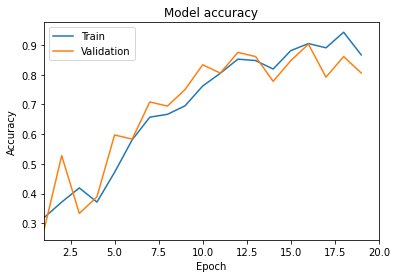

In [ ]:
# Plot accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(1, 20)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

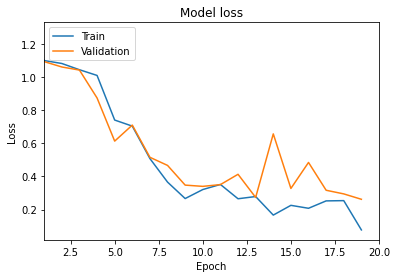

In [ ]:
# Plot loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(1, 20)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()